In [1]:
%pylab
import serial
from time import sleep

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# sudo chmod a+rw /dev/ttyUSB0
baudrate = 115200
port     = '/dev/ttyUSB0'
ser_arduino = serial.Serial(port,baudrate, timeout=0.1)

In [5]:
def get_data(n_buffers):
    buf0_size = 256;
    buf1_size = 4*buf0_size;
    buf2_size = 2*buf0_size;
    buf1 = zeros(buf1_size)
    buf2 = zeros(buf2_size)

    data = zeros((2,n_buffers*buf0_size),dtype=int)

    flag_check = True    
    h = int.from_bytes(ser_arduino.read(), byteorder='big', signed=True)
    j = -1
    while j < (n_buffers-1):
        j+=1
        if flag_check :
            while (h!=-1):
                h = int.from_bytes(ser_arduino.read(), byteorder='big', signed=True)
            flag_check = False        

        # Microseconds from the start
        for i in range(0,buf1_size):
            buf1[i] = int.from_bytes(ser_arduino.read(), byteorder='big', signed=False)
        for i in range(0,buf2_size):
            buf2[i] = int.from_bytes(ser_arduino.read(), byteorder='big', signed=False)

        # Store data:
        Bit1 = reshape(buf1,(buf0_size,4))
        data[0,j*buf0_size:(j+1)*buf0_size] = Bit1[:,0] + Bit1[:,1]*2**8 + Bit1[:,2]*2**16 + Bit1[:,3]*2**24

        Bit2 = reshape(buf2,(buf0_size,2))
        data[1,j*buf0_size:(j+1)*buf0_size] = Bit2[:,0] + Bit2[:,1]*2**8

        h = int.from_bytes(ser_arduino.read(), byteorder='big', signed=True)        
    return data

Inside each buffer:
Mean dt[us]= 120.61176470588235
Std dt[us]= 0.6982170419464269
Between each buffer:
Mean dt[us]= 125259.0
Std dt[us]= 1.7320508075688772


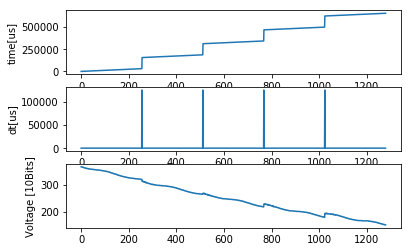

In [38]:
n_buffers = 5
data = get_data(n_buffers)

figure(1); clf();
subplot(311)
plot(data[0,:])
ylabel('time[us]')
subplot(312)
plot(diff(data[0,:]))
ylabel('dt[us]')
subplot(313)
plot(data[1,:])
ylabel('Voltage [10Bits]')

# Get the stats inside the buffers:
buf0_size = 256
d0 = data[0,:]
d1 = reshape(d0,(n_buffers,buf0_size))
dd = diff(d1,axis=1)
print('Inside each buffer:')
print('Mean dt[us]=',mean(dd))
print('Std dt[us]=',std(diff(data[1,:])))

print('Between each buffer:')
aux = zeros(n_buffers-1)
for i in range(0,n_buffers-1):
    aux[i] = data[0,(i+1)*buf0_size] - data[0,(i+1)*buf0_size-1]
print('Mean dt[us]=',mean(aux))
print('Std dt[us]=',std(aux))